# **Project: Customer Classification**  

## **Project Overview**  
This project focuses on building a machine learning model to classify bank customers based on their likelihood of opening a deposit account.  
Using historical marketing campaign data, we analyze customer behavior and develop predictive models to optimize marketing efforts.  

### **Objectives:**  
- Identify key factors that influence a customer's decision to open a deposit.  
- Train and compare different classification models (Logistic Regression, Decision Trees, Random Forest, Gradient Boosting, and Stacking).  
- Optimize model performance using hyperparameter tuning (GridSearchCV, Optuna).  
- Provide actionable insights based on feature importance analysis.  

### **Dataset Overview**  
The dataset contains information about a bank's marketing campaign, including:  
- **Customer details**: age, job type, marital status, education, account balance.  
- **Marketing campaign interactions**: contact method, last contact duration, previous campaign outcomes.  
- **Target variable**: whether the customer opened a deposit (`deposit`: yes/no).  

### **Business Value**  
Accurate customer classification allows the bank to:  
- Reduce marketing costs by targeting the right customers.  
- Increase conversion rates by understanding key influencing factors.  
- Improve overall efficiency in marketing decision-making.  


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif

## **Part 1. Data Overview, Missing Value Treatment, and Outlier Detection**

In [2]:
df = pd.read_csv('data/bank_fin.csv', sep = ';')

In [3]:
df.head(5)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,"2 343,00 $",yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,"45,00 $",no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,"1 270,00 $",yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,"2 476,00 $",yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,"184,00 $",no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB


In [5]:
# Checking for missing values in the dataset and assessing their quantity  
df.isnull().sum()

age           0
job           0
marital       0
education     0
default       0
balance      25
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
deposit       0
dtype: int64

In [6]:
# Analyzing the 'job' feature for missing values and identifying potential anomalies  
df['job'].value_counts()

job
management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: count, dtype: int64

In [7]:
# Converting the 'balance' feature to a properly formatted float value  
df['balance'] = df['balance'].apply(lambda x: 0 if x == '0  $ ' else float(str(x).split(',')[0].replace(' ', '')))  
print(round(df['balance'].mean(), 3))

1529.129


In [8]:
# Handling missing values in the 'balance' feature by replacing them with the median value  
df['balance'] = df['balance'].fillna(df['balance'].median())  
print(round(df['balance'].mean(), 3))

1526.936


In [9]:
df['education'].mode().to_frame()['education'].iloc[0]

'secondary'

In [10]:
# Handling missing values in categorical features: 'job' and 'education'  
# Replacing 'unknown' values with the mode (most frequent value) 
df['job']=df['job'].apply(lambda x: df['job'].mode().to_frame()['job'].iloc[0] if x == 'unknown' else x)
df['education']=df['education'].apply(lambda x: df['education'].mode().to_frame()['education'].iloc[0] if x == 'unknown' else x)
print(round(df[(df['education']==df['education'].mode().to_frame()['education'].iloc[0]) & (df['job']==df['job'].mode().to_frame()['job'].iloc[0])]['balance'].mean(), 3))

1598.883


In [11]:
# Removing all outliers in the 'balance' feature using the IQR method  
def outliers_iqr(data, feature):  
    x = data[feature]  
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75)  
    iqr = quartile_3 - quartile_1  
    lower_bound = quartile_1 - (iqr * 1.5)  
    upper_bound = quartile_3 + (iqr * 1.5)  
    outliers = data[(x < lower_bound) | (x > upper_bound)]  
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]  
    return outliers, cleaned, lower_bound, upper_bound  

# Identifying and removing outliers in 'balance'  
outliers, df_cleaned, lower_bound, upper_bound = outliers_iqr(df, 'balance')  
print(f'Number of outliers detected using Tukey’s method: {outliers.shape[0]}')  
print(f'Final number of records after removal: {df_cleaned.shape[0]}')  
print(round(lower_bound))  
print(round(upper_bound))  

Number of outliers detected using Tukey’s method: 1057
Final number of records after removal: 10105
-2241
4063


## **Part 2: Exploratory Data Analysis (EDA)**

Sessions without purchase: 4681


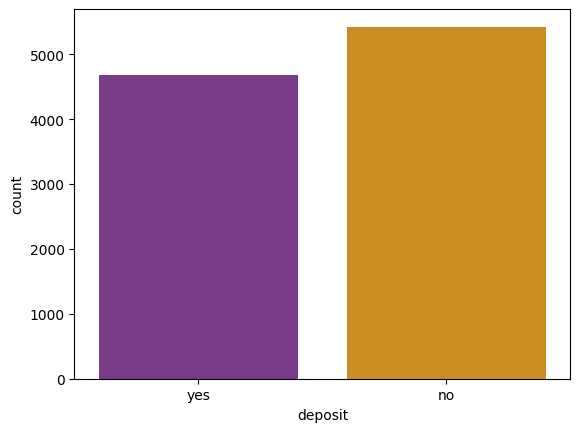

In [12]:
# Examining class distribution to check for imbalance  
sns.countplot(x='deposit', data=df_cleaned, palette='CMRmap')  

# Calculating the proportion of each class  
class_percent = df_cleaned['deposit'].value_counts()  
print('Sessions without purchase: {}'.format(class_percent.loc['yes']))  

,age,balance,day,duration,campaign,pdays,previous
count,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000
mean,40.895497,807.653538,15.590302,368.742603,2.517170,51.319644,0.816230
std,11.734931,994.151966,8.441510,346.651524,2.707159,109.644179,2.243795
min,18.000000,-2049.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,95.000000,8.000000,137.000000,1.000000,-1.000000,0.000000
50%,38.000000,445.000000,15.000000,252.000000,2.000000,-1.000000,0.000000
75%,48.000000,1227.000000,22.000000,490.000000,3.000000,2.000000,1.000000
max,95.000000,4063.000000,31.000000,3881.000000,43.000000,854.000000,58.000000


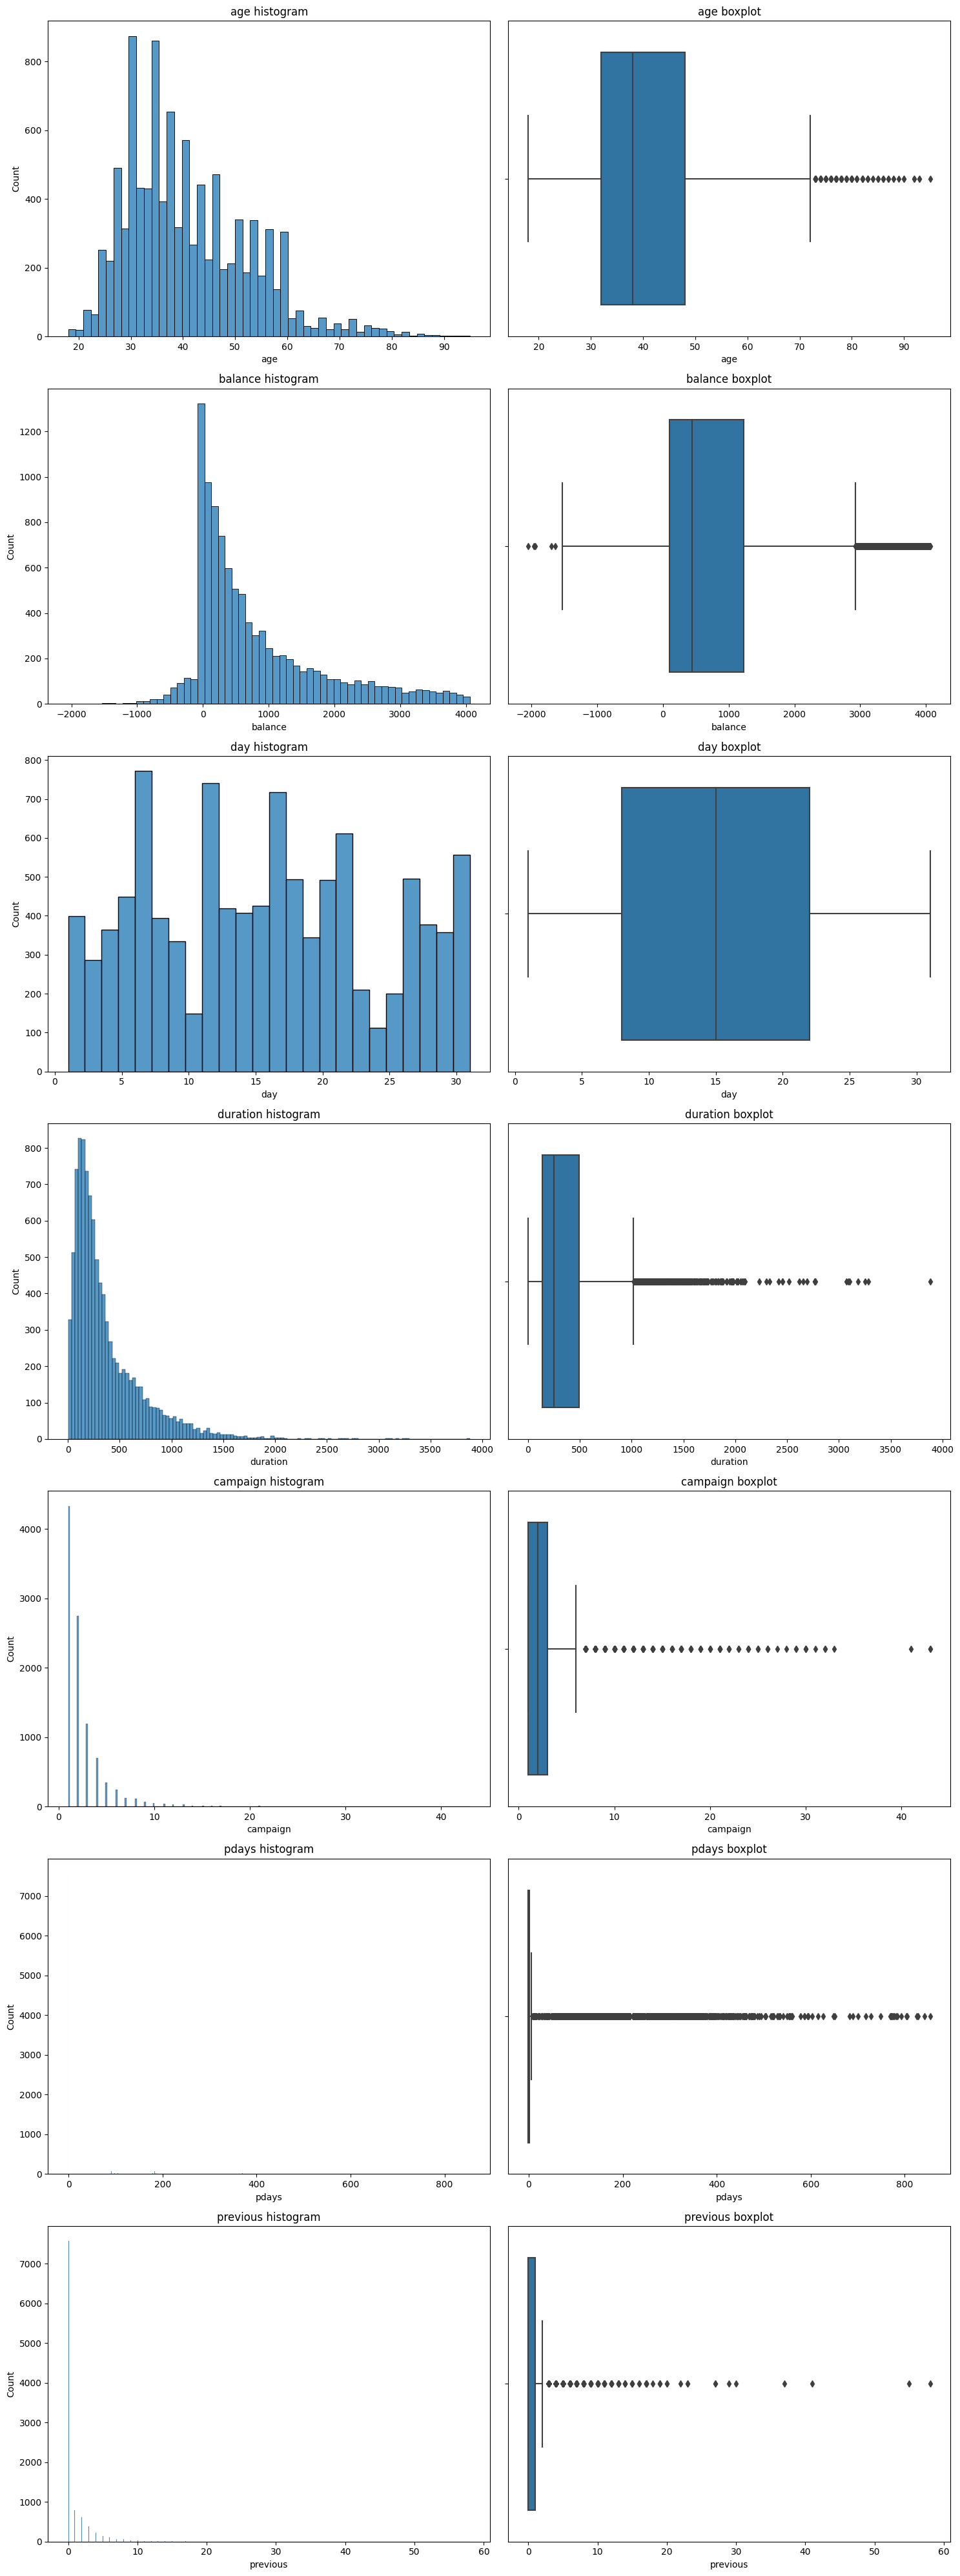

In [13]:
# Calculating descriptive statistics for numerical variables  

# Identifying numerical features  
types = df_cleaned.dtypes  
num_features = list(types[(types != 'object')].index)  

n = len(num_features)  # Number of numerical features  
fig, axes = plt.subplots(n, 2, figsize=(15, 40))  # Creating a figure with n x 2 subplots  

# Looping through all numerical features  
for i, feature in enumerate(num_features):  # i - index, feature - feature name in the dataset  
    # Plotting the histogram for feature distribution  
    histplot = sns.histplot(data=df_cleaned, x=feature, ax=axes[i][0])  
    histplot.set_title('{} histogram'.format(feature))  # Adding a title to the plot  

    # Plotting the boxplot to visualize outliers  
    box_plot = sns.boxplot(data=df_cleaned, x=feature, ax=axes[i][1])  
    box_plot.set_title('{} boxplot'.format(feature))  # Adding a title to the plot  

plt.tight_layout()  # Adjusting layout for better readability  

# Displaying summary statistics  
df_cleaned.describe()  

,job,marital,education,default,housing,loan,contact,month,poutcome,deposit
count,10105,10105,10105,10105,10105,10105,10105,10105,10105,10105
unique,11,3,3,2,2,2,3,12,4,2
top,management,married,secondary,no,no,no,cellular,may,unknown,no
freq,2315,5715,5517,9939,5243,8712,7283,2617,7570,5424


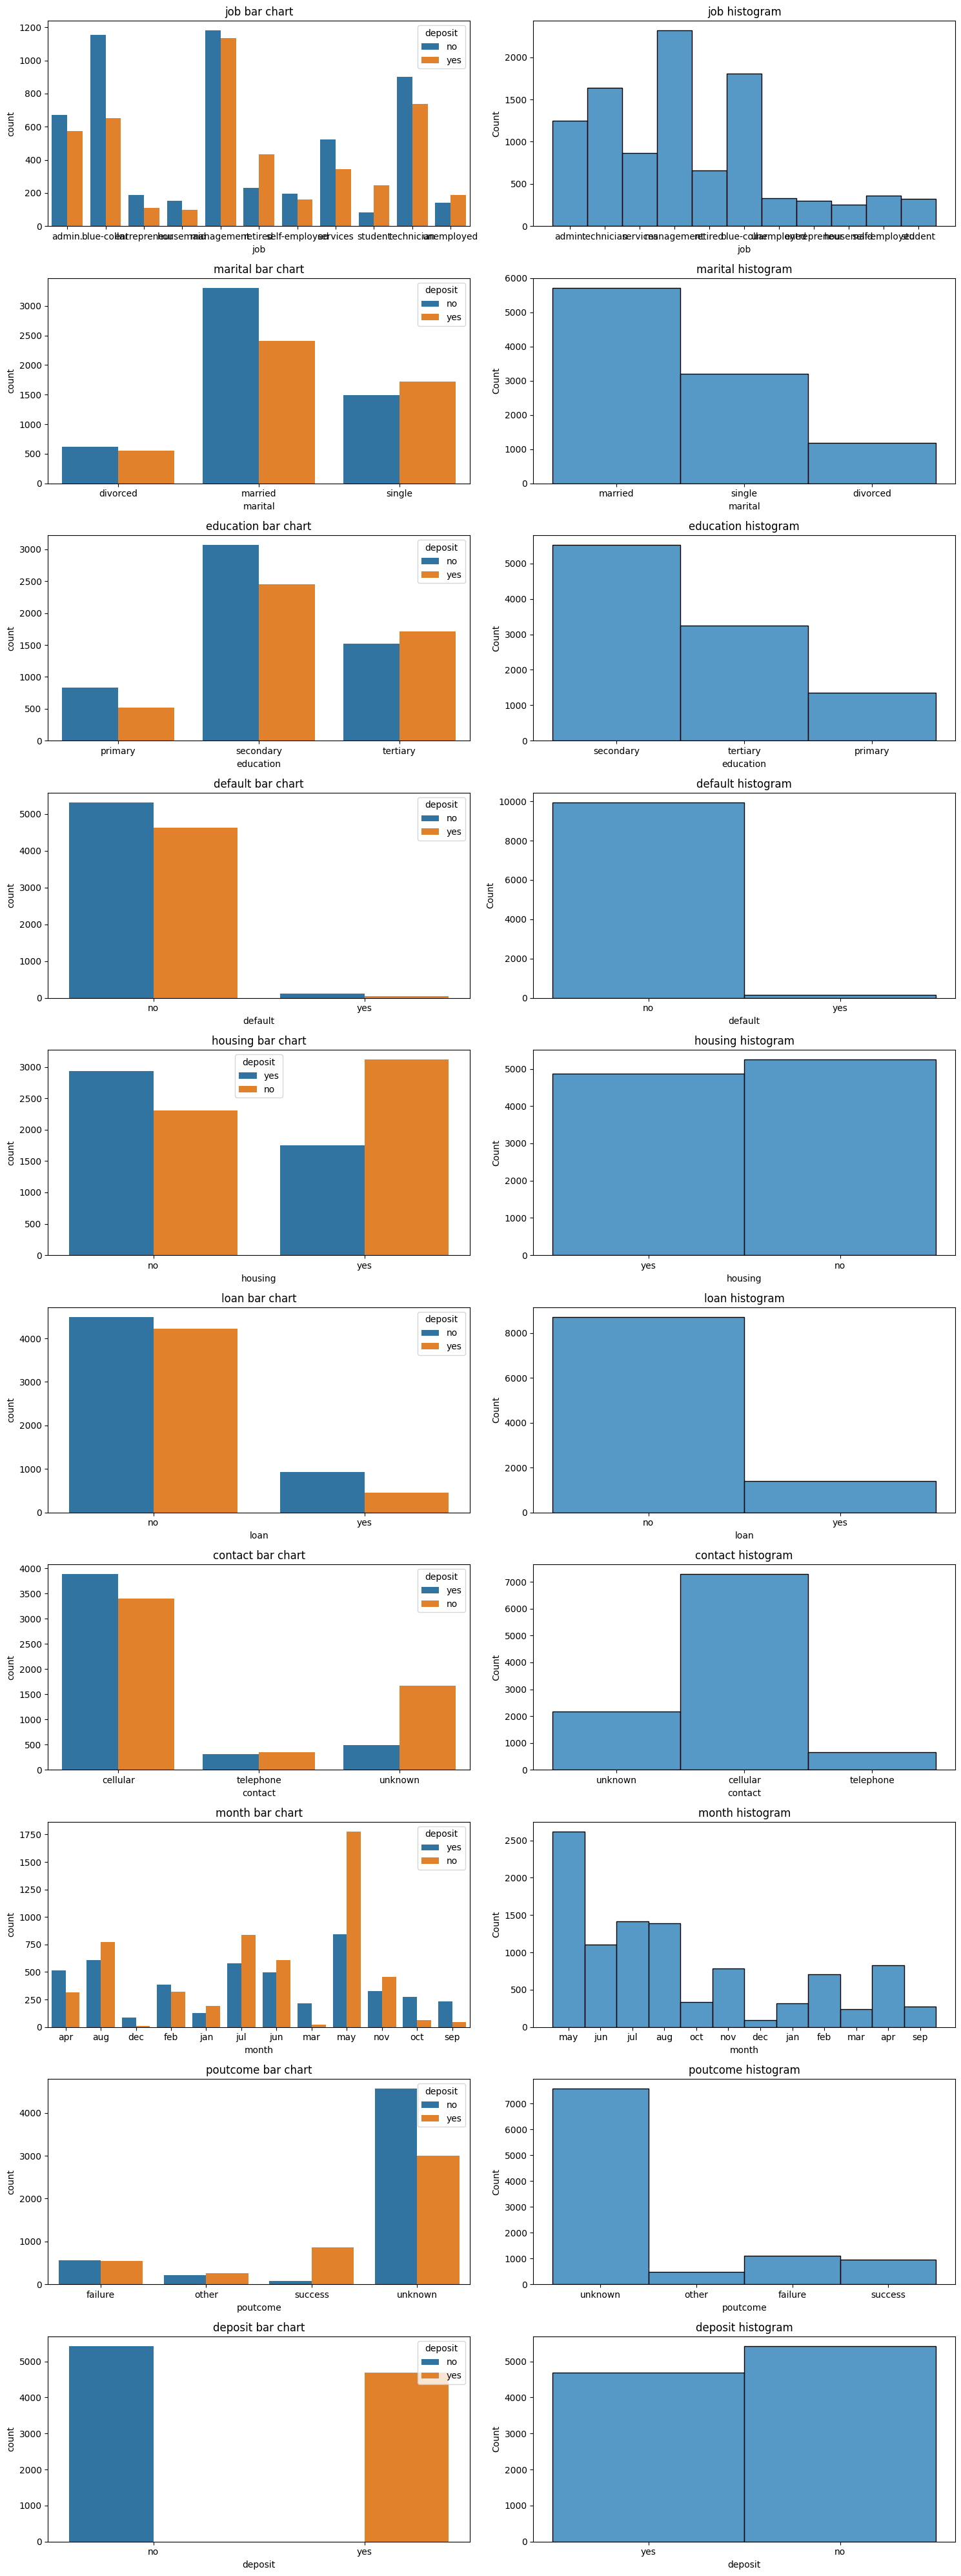

In [14]:
# Calculating descriptive statistics for categorical variables  
# Generating visualizations to illustrate the results  

obj_features = list(types[(types == 'object')].index)  

n = len(obj_features)  # Number of categorical features  
fig, axes = plt.subplots(n, 2, figsize=(15, 40))  # Creating a figure with n x 2 subplots  

# Looping through all categorical features  
for i, feature in enumerate(obj_features):  # i - index, feature - feature name in the dataset  
    # Creating a grouped dataset based on the 'deposit' feature  
    bar_data = df_cleaned.groupby(by=feature, as_index=False)['deposit'].value_counts()  

    # Plotting a bar chart to visualize category distribution  
    barplot = sns.barplot(data=bar_data, x=feature, y='count', hue='deposit', ax=axes[i][0])  
    barplot.set_title('{} bar chart'.format(feature))  # Adding a title to the plot  

    # Plotting a histogram for feature distribution  
    histplot = sns.histplot(data=df_cleaned, x=feature, ax=axes[i][1])  
    histplot.set_title('{} histogram'.format(feature))  # Adding a title to the plot  

plt.tight_layout()  # Adjusting layout for better readability  

# Displaying summary statistics for categorical variables  
df_cleaned.describe(include='object')  

In [15]:
# Determining which outcome of the previous marketing campaign  
# has a higher success rate in the current campaign compared to failures  
df_cleaned[['poutcome', 'deposit']].value_counts().sort_index()

poutcome  deposit
failure   no          562
          yes         547
other     no          216
          yes         265
success   no           84
          yes         861
unknown   no         4562
          yes        3008
Name: count, dtype: int64

In [16]:
# Identifying the month with the highest rejection rate for opening a deposit  
df_cleaned[['month', 'deposit']].value_counts().sort_index()

month  deposit
apr    no          317
       yes         513
aug    no          775
       yes         610
dec    no            9
       yes          84
feb    no          323
       yes         386
jan    no          194
       yes         125
jul    no          836
       yes         582
jun    no          606
       yes         498
mar    no           24
       yes         213
may    no         1776
       yes         841
nov    no          456
       yes         324
oct    no           62
       yes         273
sep    no           46
       yes         232
Name: count, dtype: int64

In [17]:
# Creating age groups and determining which groups are more likely  
# to open a deposit rather than reject the offer  

def get_age_group(x):  
    if x < 30:  
        return '<30'  
    elif 30 <= x < 40:  
        return '30-40'  
    elif 40 <= x < 50:  
        return '40-50'  
    elif 50 <= x < 60:  
        return '50-60'  
    else:  
        return '60+'  

df_cleaned['age_groups'] = df_cleaned['age'].apply(get_age_group)  

import plotly  
import plotly.express as px  

# Grouping data by age group and deposit status  
bar_data = df_cleaned.groupby(by='age_groups', as_index=False)['deposit'].value_counts()  

# Creating a bar chart to visualize deposit openings by age group  
fig = px.bar(  
    data_frame=bar_data,  
    x="age_groups",  
    y="count",  
    color="deposit",  
    labels={'deposit': 'Deposit opened',  
            'count': 'Number of clients',  
            'age_groups': 'Client age group'},  
    barmode="group",  
    orientation='v',  
    title='Deposit openings by age group'  
)  

fig.show()

In [18]:
# Visualizing deposit openings and rejections based on marital status  

# Grouping data by marital status and deposit status  
bar_data = df_cleaned.groupby(by='marital', as_index=False)['deposit'].value_counts()  

# Creating a bar chart to show deposit openings by marital status  
fig = px.bar(  
    data_frame=bar_data,  
    x="marital",  
    y="count",  
    color="deposit",  
    labels={'deposit': 'Deposit opened',  
            'count': 'Number of clients',  
            'marital': 'Marital status'},  
    barmode="group",  
    orientation='v',  
    title='Deposit openings by marital status'  
)  

fig.show()

In [19]:
# Visualizing deposit openings and rejections based on education level  

# Grouping data by education level and deposit status  
bar_data = df_cleaned.groupby(by='education', as_index=False)['deposit'].value_counts()  

# Creating a bar chart to show deposit openings by education level  
fig = px.bar(  
    data_frame=bar_data,  
    x="education",  
    y="count",  
    color="deposit",  
    labels={'deposit': 'Deposit opened',  
            'count': 'Number of clients',  
            'education': 'Education level'},  
    barmode="group",  
    orientation='v',  
    title='Deposit openings by education level'  
)  

fig.show()

In [20]:
# Visualizing deposit openings and rejections based on job type  

# Grouping data by job type and deposit status  
bar_data = df_cleaned.groupby(by='job', as_index=False)['deposit'].value_counts()  

# Creating a bar chart to show deposit openings by job type  
fig = px.bar(  
    data_frame=bar_data,  
    x="job",  
    y="count",  
    color="deposit",  
    labels={'deposit': 'Deposit opened',  
            'count': 'Number of clients',  
            'job': 'Job type'},  
    barmode="group",  
    orientation='v',  
    title='Deposit openings by job type'  
)  

fig.show()

Text(50.722222222222214, 0.5, 'Education level')

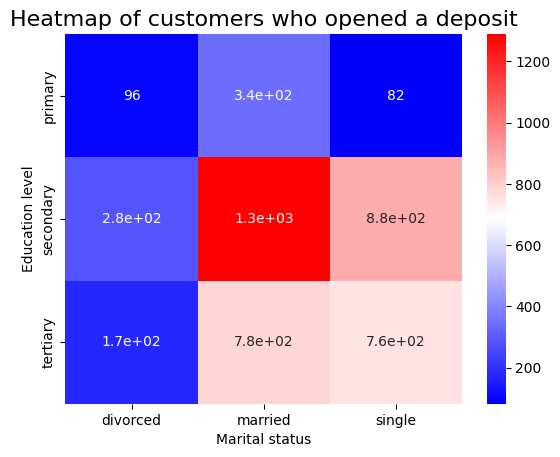

In [21]:
# Creating a pivot table to determine which education and marital status  
# groups are most represented among those who opened a deposit  

df_depo_yes = df_cleaned[df_cleaned['deposit'] == 'yes']  

pivot_yes = df_depo_yes.pivot_table(  
    values='deposit',  
    columns='marital',  
    index='education',  
    aggfunc='count'  
)  

# Creating a heatmap to visualize the distribution  
heatmap = sns.heatmap(data=pivot_yes, cmap='bwr', annot=True)  
heatmap.set_title('Heatmap of customers who opened a deposit', fontsize=16)  
heatmap.set_xlabel('Marital status')  
heatmap.set_ylabel('Education level')  

Text(50.722222222222214, 0.5, 'Education level')

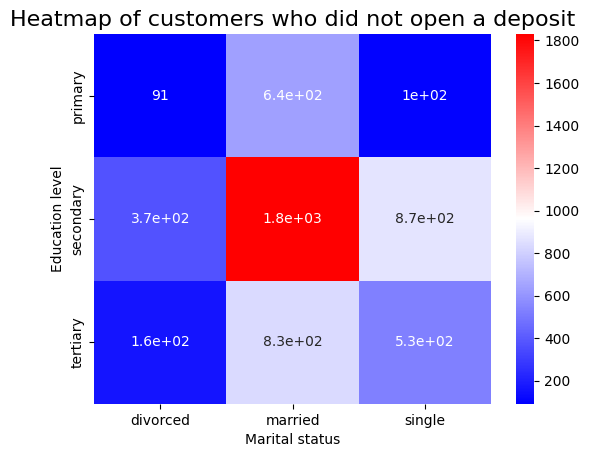

In [22]:
# Creating a pivot table to determine which education and marital status  
# groups are most represented among those who did not open a deposit  

df_depo_no = df_cleaned[df_cleaned['deposit'] == 'no']  

pivot_no = df_depo_no.pivot_table(  
    values='deposit',  
    columns='marital',  
    index='education',  
    aggfunc='count'  
)  

# Creating a heatmap to visualize the distribution  
heatmap = sns.heatmap(data=pivot_no, cmap='bwr', annot=True)  
heatmap.set_title('Heatmap of customers who did not open a deposit', fontsize=16)  
heatmap.set_xlabel('Marital status')  
heatmap.set_ylabel('Education level')  

## **Part 3: Data Transformation**

In [23]:
# Encoding education levels using Label Encoding  
le = LabelEncoder()  
le.fit(df_cleaned['education'])  
df_cleaned['education'] = le.transform(df_cleaned['education'])  
df_cleaned['education'].sum()  

11995

In [24]:
le=LabelEncoder()
le.fit(df_cleaned['age_groups'])
df_cleaned['age_groups']=le.transform(df_cleaned['age_groups'])

In [25]:
# Converting binary variables into a 0 and 1 representation  
df_cleaned['deposit'] = df_cleaned['deposit'].apply(lambda x: 1 if x == 'yes' else 0)  
df_cleaned['default'] = df_cleaned['default'].apply(lambda x: 1 if x == 'yes' else 0)  
df_cleaned['housing'] = df_cleaned['housing'].apply(lambda x: 1 if x == 'yes' else 0)  
df_cleaned['loan'] = df_cleaned['loan'].apply(lambda x: 1 if x == 'yes' else 0)  

# Calculating the sum of the mean values for default, housing, and loan features  
print(round(df_cleaned['default'].mean() + df_cleaned['housing'].mean() + df_cleaned['loan'].mean(), 3))  

0.635


In [26]:
df.shape

(11162, 17)

In [27]:
df_cleaned.describe(include='object')

,job,marital,contact,month,poutcome
count,10105,10105,10105,10105,10105
unique,11,3,3,12,4
top,management,married,cellular,may,unknown
freq,2315,5715,7283,2617,7570


In [28]:
# Creating dummy variables for categorical features  
df_dummies = pd.get_dummies(df_cleaned, columns=['job', 'marital', 'contact', 'month', 'poutcome'], drop_first=False)  

# Displaying dataset information after encoding  
df_dummies.info()  

<class 'pandas.core.frame.DataFrame'>
Index: 10105 entries, 0 to 11161
Data columns (total 46 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                10105 non-null  int64  
 1   education          10105 non-null  int32  
 2   default            10105 non-null  int64  
 3   balance            10105 non-null  float64
 4   housing            10105 non-null  int64  
 5   loan               10105 non-null  int64  
 6   day                10105 non-null  int64  
 7   duration           10105 non-null  int64  
 8   campaign           10105 non-null  int64  
 9   pdays              10105 non-null  int64  
 10  previous           10105 non-null  int64  
 11  deposit            10105 non-null  int64  
 12  age_groups         10105 non-null  int32  
 13  job_admin.         10105 non-null  bool   
 14  job_blue-collar    10105 non-null  bool   
 15  job_entrepreneur   10105 non-null  bool   
 16  job_housemaid      10105 no

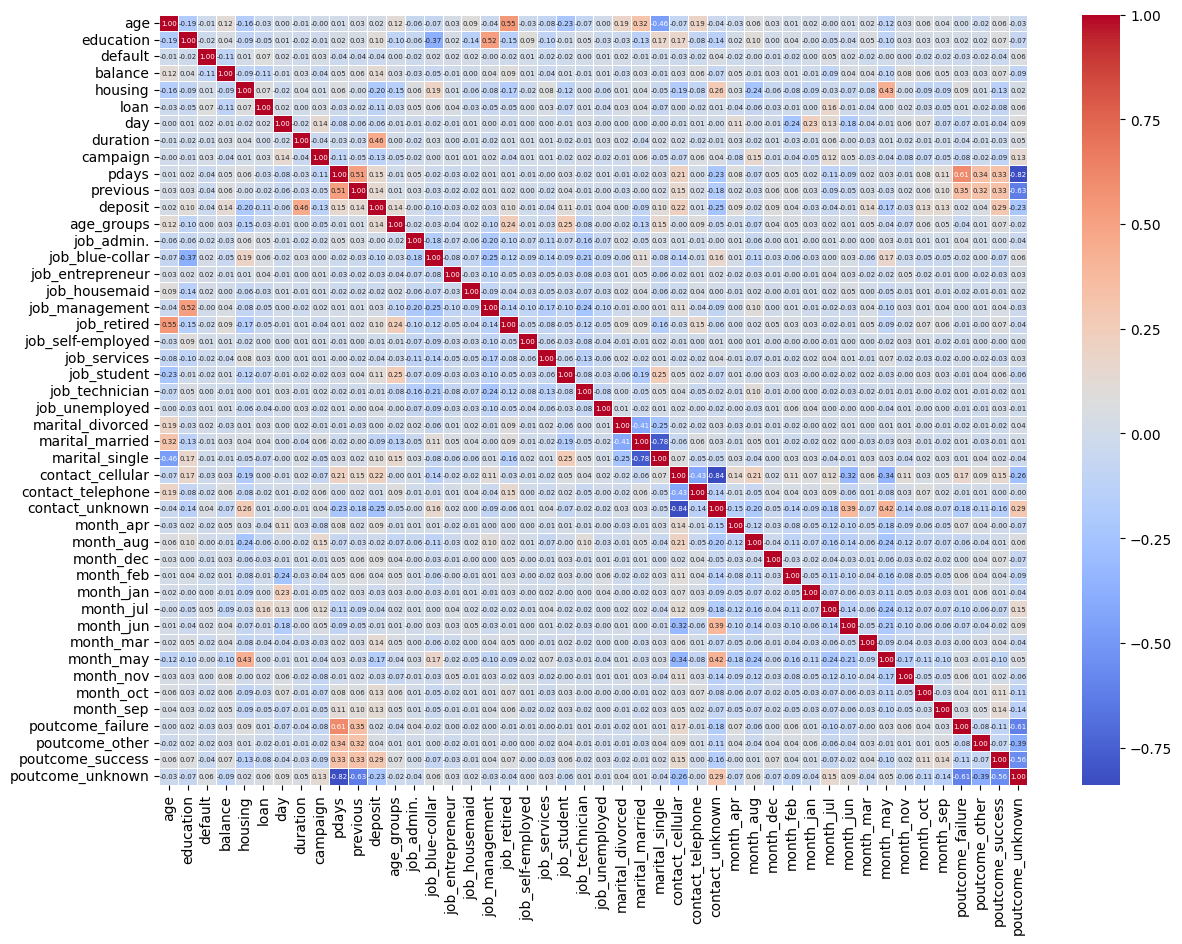

In [51]:
# Building a correlation matrix to assess multicollinearity  
plt.figure(figsize=(14,10))  
ax = sns.heatmap(df_dummies.corr(), annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5, annot_kws={"size": 5})  
plt.show()  

In [30]:
# Splitting the dataset into features and target variable  
X = df_dummies.drop(['deposit'], axis=1)  
y = df_dummies['deposit']  

# Splitting the data into training and test sets  
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42, test_size=0.33)  


In [31]:
# Calculating key statistics  
y.mean()  

0.4632360217714003

In [32]:
# Selecting the 15 most relevant features using SelectKBest  
selector = SelectKBest(f_classif, k=15)  
selector = selector.fit(X_train, y_train)  

# Getting the names of the selected features  
columns = selector.get_feature_names_out()  

# Keeping only the selected features in the training and test sets  
X_train = X_train[columns]  
X_test = X_test[columns]  

In [33]:
# Normalizing data using MinMaxScaler  
mm_scaler = preprocessing.MinMaxScaler()  
mm_scaler.fit(X_train)  
X_train_scaled = mm_scaler.transform(X_train)  
X_test_scaled = mm_scaler.transform(X_test)  

# Converting scaled data back to DataFrame with original column names  
X_train_scaled = pd.DataFrame(X_train_scaled, columns=columns)  
X_test_scaled = pd.DataFrame(X_test_scaled, columns=columns)  

# Calculating the mean balance after scaling  
X_test_scaled['balance'].mean().round(2)  

0.47

## **Part 4: Solving the Classification Task: Logistic Regression and Decision Trees**

In [34]:
# Training a logistic regression model and calculating performance metrics  
log_clf = linear_model.LogisticRegression(max_iter=1000, random_state=42, solver='sag')  

# Fitting the model to the training data  
log_clf.fit(X_train_scaled, y_train)  

# Making predictions on the training and test sets  
y_train_pred = log_clf.predict(X_train_scaled)  
y_test_pred = log_clf.predict(X_test_scaled)  

# Evaluating model performance using accuracy and classification report  
print(f'Accuracy score for logistic regression on the training set: {round(metrics.accuracy_score(y_train, y_train_pred), 2)}')  
print(metrics.classification_report(y_train, y_train_pred))  

print(f'Accuracy score for logistic regression on the test set: {round(metrics.accuracy_score(y_test, y_test_pred), 2)}')  
print(metrics.classification_report(y_test, y_test_pred))  

Accuracy score for logistic regression on the training set: 0.82
              precision    recall  f1-score   support

           0       0.81      0.88      0.84      3634
           1       0.84      0.76      0.80      3136

    accuracy                           0.82      6770
   macro avg       0.83      0.82      0.82      6770
weighted avg       0.83      0.82      0.82      6770

Accuracy score for logistic regression on the test set: 0.8
              precision    recall  f1-score   support

           0       0.79      0.87      0.83      1790
           1       0.83      0.73      0.78      1545

    accuracy                           0.80      3335
   macro avg       0.81      0.80      0.80      3335
weighted avg       0.81      0.80      0.80      3335



In [35]:
# Training a decision tree classifier and tuning the maximum depth  
dt_clf = tree.DecisionTreeClassifier(criterion='entropy', random_state=42, max_depth=6)  

# Fitting the model to the training data  
dt_clf.fit(X_train_scaled, y_train)  

# Making predictions on the training and test sets  
y_train_pred = dt_clf.predict(X_train_scaled)  
y_test_pred = dt_clf.predict(X_test_scaled)  

# Evaluating model performance using accuracy and classification report  
print(f'Accuracy score for decision tree on the training set: {round(metrics.accuracy_score(y_train, y_train_pred), 2)}')  
print(metrics.classification_report(y_train, y_train_pred))  

print(f'Accuracy score for decision tree on the test set: {round(metrics.accuracy_score(y_test, y_test_pred), 2)}')  
print(metrics.classification_report(y_test, y_test_pred))  

Accuracy score for decision tree on the training set: 0.82
              precision    recall  f1-score   support

           0       0.86      0.79      0.82      3634
           1       0.78      0.85      0.81      3136

    accuracy                           0.82      6770
   macro avg       0.82      0.82      0.82      6770
weighted avg       0.82      0.82      0.82      6770

Accuracy score for decision tree on the test set: 0.81
              precision    recall  f1-score   support

           0       0.85      0.78      0.81      1790
           1       0.77      0.84      0.80      1545

    accuracy                           0.81      3335
   macro avg       0.81      0.81      0.81      3335
weighted avg       0.81      0.81      0.81      3335



In [36]:
from sklearn.model_selection import GridSearchCV  

# Tuning hyperparameters using GridSearchCV  
param_grid = {  
    'min_samples_split': [2, 5, 7, 10],  
    'max_depth': [3, 5, 7]  
}  

grid_search_tree = GridSearchCV(  
    estimator=tree.DecisionTreeClassifier(random_state=42, criterion='entropy'),  
    param_grid=param_grid,  
    cv=5,  
    n_jobs=-1  
)  

# Fitting the model to the training data  
grid_search_tree.fit(X_train_scaled, y_train)  

# Evaluating model performance on the training set  
y_train_pred = grid_search_tree.predict(X_train_scaled)  
print("Accuracy on the training set: {:.2f}".format(grid_search_tree.score(X_train_scaled, y_train)))  
print(metrics.classification_report(y_train, y_train_pred))  

# Evaluating model performance on the test set  
y_test_pred = grid_search_tree.predict(X_test_scaled)  
print("Accuracy on the test set: {:.2f}".format(grid_search_tree.score(X_test_scaled, y_test)))  
print("F1-score on the test set: {:.2f}".format(metrics.f1_score(y_test, y_test_pred)))  
print(metrics.classification_report(y_test, y_test_pred))  

# Displaying the best hyperparameter values  
print("Best hyperparameter values: {}".format(grid_search_tree.best_params_))  

Accuracy on the training set: 0.84
              precision    recall  f1-score   support

           0       0.86      0.84      0.85      3634
           1       0.81      0.84      0.82      3136

    accuracy                           0.84      6770
   macro avg       0.83      0.84      0.84      6770
weighted avg       0.84      0.84      0.84      6770

Accuracy on the test set: 0.82
F1-score on the test set: 0.81
              precision    recall  f1-score   support

           0       0.84      0.82      0.83      1790
           1       0.79      0.82      0.81      1545

    accuracy                           0.82      3335
   macro avg       0.82      0.82      0.82      3335
weighted avg       0.82      0.82      0.82      3335

Best hyperparameter values: {'max_depth': 7, 'min_samples_split': 10}


## **Part 5: Solving the Classification Task: Ensemble Models and Prediction**

In [37]:
# Training a Random Forest classifier on our dataset  
rf_clf = ensemble.RandomForestClassifier(  
    n_estimators=100,  
    criterion='gini',  
    min_samples_leaf=5,  
    max_depth=10,  
    random_state=42  
)  

# Fitting the model to the training data  
rf_clf.fit(X_train_scaled, y_train)  

# Making predictions on the training and test sets  
y_train_pred = rf_clf.predict(X_train_scaled)  
y_test_pred = rf_clf.predict(X_test_scaled)  

# Evaluating model performance using accuracy and classification report  
print(f'Accuracy score for Random Forest on the training set: {round(metrics.accuracy_score(y_train, y_train_pred), 2)}')  
print(metrics.classification_report(y_train, y_train_pred))  

print(f'Accuracy score for Random Forest on the test set: {round(metrics.accuracy_score(y_test, y_test_pred), 2)}')  
print(metrics.classification_report(y_test, y_test_pred))  

Accuracy score for Random Forest on the training set: 0.86
              precision    recall  f1-score   support

           0       0.88      0.86      0.87      3634
           1       0.84      0.86      0.85      3136

    accuracy                           0.86      6770
   macro avg       0.86      0.86      0.86      6770
weighted avg       0.86      0.86      0.86      6770

Accuracy score for Random Forest on the test set: 0.83
              precision    recall  f1-score   support

           0       0.85      0.82      0.84      1790
           1       0.80      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



In [38]:
# Using Gradient Boosting for classification and comparing performance with Random Forest  
from sklearn.ensemble import GradientBoostingClassifier  

gb = GradientBoostingClassifier(  
    learning_rate=0.05,  # Learning rate  
    n_estimators=300,  # Number of trees  
    min_samples_leaf=5,  
    max_depth=5,  # Maximum tree depth  
    random_state=42  # Random seed  
)  

# Fitting the model to the training data  
gb.fit(X_train_scaled, y_train)  

# Making predictions on the training and test sets  
y_train_pred = gb.predict(X_train_scaled)  
y_test_pred = gb.predict(X_test_scaled)  

# Evaluating model performance using accuracy and classification report  
print(f'Accuracy score for Gradient Boosting on the training set: {round(metrics.accuracy_score(y_train, y_train_pred), 2)}')  
print(metrics.classification_report(y_train, y_train_pred))  

print(f'Accuracy score for Gradient Boosting on the test set: {round(metrics.accuracy_score(y_test, y_test_pred), 2)}')  
print(metrics.classification_report(y_test, y_test_pred))  

Accuracy score for Gradient Boosting on the training set: 0.89
              precision    recall  f1-score   support

           0       0.90      0.89      0.89      3634
           1       0.87      0.89      0.88      3136

    accuracy                           0.89      6770
   macro avg       0.89      0.89      0.89      6770
weighted avg       0.89      0.89      0.89      6770

Accuracy score for Gradient Boosting on the test set: 0.83
              precision    recall  f1-score   support

           0       0.85      0.82      0.84      1790
           1       0.80      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



In [39]:
# Combining known algorithms using stacking  
from sklearn.ensemble import StackingClassifier  

# Creating a list of tuples in the format: (model name, model)  
estimators = [  
    ('lr', linear_model.LogisticRegression(max_iter=1000, random_state=42, solver='sag')),  
    ('dt', tree.DecisionTreeClassifier(criterion='entropy', random_state=42, max_depth=6)),  
    ('gb', GradientBoostingClassifier(learning_rate=0.05, n_estimators=300, min_samples_leaf=5, max_depth=5, random_state=42))  
]  

# Creating a stacking classifier object  
reg = StackingClassifier(  
    estimators=estimators,  # Base models in stacking  
    final_estimator=linear_model.LogisticRegression(  # Meta-model  
        max_iter=1000,  
        solver='sag',  
        random_state=42  # Random seed  
    )  
)  

# Training the model  
reg.fit(X_train_scaled, y_train)  

# Making predictions on the training and test sets  
y_train_pred = reg.predict(X_train_scaled)  
y_test_pred = reg.predict(X_test_scaled)  

# Evaluating model performance using accuracy and classification report  
print(f'Accuracy score for stacking on the training set: {round(metrics.accuracy_score(y_train, y_train_pred), 2)}')  
print(metrics.classification_report(y_train, y_train_pred))  

print(f'Accuracy score for stacking on the test set: {round(metrics.accuracy_score(y_test, y_test_pred), 2)}')  
print(metrics.classification_report(y_test, y_test_pred))  

Accuracy score for stacking on the training set: 0.87
              precision    recall  f1-score   support

           0       0.88      0.88      0.88      3634
           1       0.86      0.86      0.86      3136

    accuracy                           0.87      6770
   macro avg       0.87      0.87      0.87      6770
weighted avg       0.87      0.87      0.87      6770

Accuracy score for stacking on the test set: 0.82
              precision    recall  f1-score   support

           0       0.83      0.83      0.83      1790
           1       0.80      0.81      0.81      1545

    accuracy                           0.82      3335
   macro avg       0.82      0.82      0.82      3335
weighted avg       0.82      0.82      0.82      3335



In [40]:
# Evaluating which features have the highest importance in the Gradient Boosting model  
from sklearn.feature_selection import RFE  

# Defining the estimator (Gradient Boosting Classifier)  
estimator = GradientBoostingClassifier(  
    learning_rate=0.05,  
    n_estimators=300,  
    min_samples_leaf=5,  
    max_depth=5,  
    random_state=42  
)  

# Performing Recursive Feature Elimination (RFE) to select the top 3 most important features  
selector = RFE(estimator, n_features_to_select=3, step=1)  
selector = selector.fit(X_train_scaled, y_train)  

# Getting the names of the selected features  
selector.get_feature_names_out()  

array(['balance', 'duration', 'poutcome_success'], dtype=object)

In [41]:
# Performing hyperparameter optimization using Optuna  
import optuna  

random_state = 42  

def optuna_rf(trial):  
    # Defining the hyperparameter search space  
    n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)  
    max_depth = trial.suggest_int('max_depth', 10, 30, 1)  
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)  

    # Creating the model  
    model = ensemble.RandomForestClassifier(  
        n_estimators=n_estimators,  
        max_depth=max_depth,  
        min_samples_leaf=min_samples_leaf,  
        random_state=random_state  
    )  

    # Training the model  
    model.fit(X_train_scaled, y_train)  
    score = metrics.f1_score(y_train, model.predict(X_train_scaled))  

    return score  

# Creating an Optuna study for hyperparameter tuning  
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")  

# Running the optimization process with n_trials iterations  
study.optimize(optuna_rf, n_trials=20)  

# Displaying the best hyperparameter values found on the training set  
print("Best hyperparameter values: {}".format(study.best_params))  
print("F1-score on the training set: {:.2f}".format(study.best_value))  

# Evaluating the model on the test set  
model = ensemble.RandomForestClassifier(**study.best_params, random_state=random_state)  
model.fit(X_train_scaled, y_train)  

# Calculating accuracy and F1-score on the test set  
y_train_pred = model.predict(X_train_scaled)  
print("Accuracy on the test set: {:.2f}".format(model.score(X_test_scaled, y_test)))  

y_test_pred = model.predict(X_test_scaled)  
print("F1-score on the test set: {:.2f}".format(metrics.f1_score(y_test, y_test_pred)))  
print(metrics.classification_report(y_test, y_test_pred))  

[I 2025-02-09 16:06:25,359] A new study created in memory with name: RandomForestClassifier
[I 2025-02-09 16:06:25,831] Trial 0 finished with value: 0.855623338025966 and parameters: {'n_estimators': 156, 'max_depth': 12, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.855623338025966.
[I 2025-02-09 16:06:26,418] Trial 1 finished with value: 0.852037617554859 and parameters: {'n_estimators': 198, 'max_depth': 26, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.855623338025966.
[I 2025-02-09 16:06:26,737] Trial 2 finished with value: 0.8566073102155577 and parameters: {'n_estimators': 105, 'max_depth': 18, 'min_samples_leaf': 7}. Best is trial 2 with value: 0.8566073102155577.
[I 2025-02-09 16:06:27,093] Trial 3 finished with value: 0.844724409448819 and parameters: {'n_estimators': 121, 'max_depth': 24, 'min_samples_leaf': 10}. Best is trial 2 with value: 0.8566073102155577.
[I 2025-02-09 16:06:27,665] Trial 4 finished with value: 0.8525410476935106 and parameters: {'n_esti

Best hyperparameter values: {'n_estimators': 179, 'max_depth': 28, 'min_samples_leaf': 2}
F1-score on the training set: 0.93
Accuracy on the test set: 0.82
F1-score on the test set: 0.82
              precision    recall  f1-score   support

           0       0.85      0.81      0.83      1790
           1       0.79      0.84      0.82      1545

    accuracy                           0.82      3335
   macro avg       0.82      0.83      0.82      3335
weighted avg       0.83      0.82      0.83      3335



# **Final Results & Conclusion**  

## **Model Performance Comparison**  
We evaluated multiple classification models to determine the best approach for predicting whether a customer will open a deposit.  

| Model                  | Training Accuracy | Test Accuracy | F1-Score (Test) |
|------------------------|------------------|--------------|----------------|
| Logistic Regression    | 82%              | 80%          | 0.78             |
| Decision Tree         | 84%              | 82%          | 0.81             |
| Random Forest        | 86%              | 83%          | 0.82             |
| Gradient Boosting     | 89%              | 83%          | 0.82             |
| Stacking Model        | 87%              | 82%          | 0.81             |

### **Final Thoughts on Model Performance**  
- The **Random Forest model** showed the best balance of accuracy and F1-score.  
- While **Gradient Boosting** had a higher accuracy, it was slightly more prone to overfitting.  
- **Stacking did not provide significant improvement**, indicating that base models already capture most patterns. 

Feature importance analysis revealed that **balance, duration, and poutcome_success** were the most influential predictors.  

---

## **Key Insights & Business Impact**  
🔹 Customers with **higher account balances** and **longer last contact durations** were more likely to open a deposit.  
🔹 **Previous campaign success** significantly correlated with a higher probability of a positive outcome in the current campaign.  
🔹 **Some features had little impact**, meaning marketing efforts can be optimized by focusing on the most relevant customer groups.  

### **Business Recommendations:**  
✔ **Prioritize high-balance customers** and those with a positive previous campaign outcome.  
✔ **Optimize call duration strategy**, as longer conversations show a higher conversion rate.  
✔ **Use predictive models to focus marketing efforts**, reducing unnecessary customer outreach.  
